In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [36]:
# Directoy Paths
train_normal = 'CellData/chest_xray/train/NORMAL'
train_sick = 'CellData/chest_xray/train/PNEUMONIA'
test_normal = 'CellData/chest_xray/test/NORMAL'
test_sick = 'CellData/chest_xray/test/PNEUMONIA'

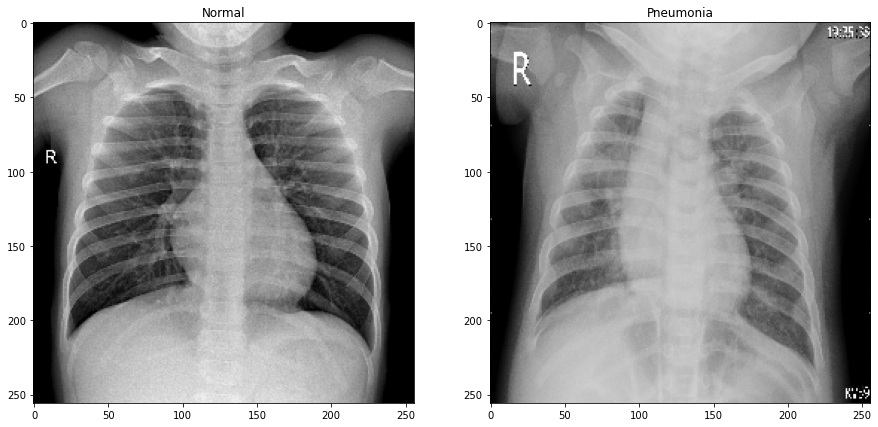

In [64]:
# Loading image:
fig, ax = plt.subplots(nrows = 1, ncols=2,figsize=(15,15))
img1 = load_img(f'{train_normal}/NORMAL-28501-0001.jpeg', target_size=(256,256))
ax[0].imshow(img1)
ax[0].set_title('Normal');
img2 = load_img(f'{train_sick}/BACTERIA-52163-0002.jpeg', target_size=(256,256))
ax[1].imshow(img2)
ax[1].set_title('Pneumonia');

## Creating the Dataset ##

In [65]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (500 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=500)

# Get all the data in the directory data/train (500 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=500)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


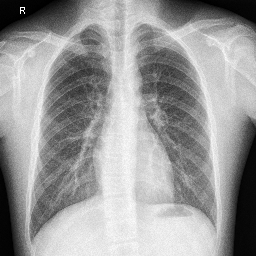

In [68]:
array_to_img(train_images[132])

In [69]:
train_labels[132]

array([1., 0.], dtype=float32)

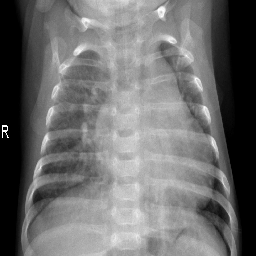

In [71]:
array_to_img(train_images[355])

In [72]:
train_labels[355]

array([0., 1.], dtype=float32)

In [73]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(500, 256, 256, 3)
(500, 2)
(500, 256, 256, 3)
(500, 2)
